In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from cvxopt import matrix, solvers

symbols = ['USIG', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI',
'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
market = ['SPY']

start = datetime.datetime(2019,1,1)
end = datetime.datetime(2024,1,1)

In [3]:
def get_prices(symbols,start,end):
    df = yf.download(symbols, start=start, end=end)
    prices = df['Adj Close']
    return prices

In [34]:
# Prices
prices = get_prices(symbols,start,end)
market_prices = get_prices(market,start,end)

# Returns
market_returns = market_prices.pct_change().dropna()
returns = prices.pct_change().dropna()

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


In [143]:
# Window Size: a single trading year
window = 100

In [144]:
def calculate_betas(returns,market_returns):
    # Cov - between non-market assets
    cov = np.cov(returns.T)
    
    # Beta - with respect to SPY
    betas = []
    for symbol in symbols:
        c=np.cov(np.array(market_returns),np.array(returns[symbol]))
        cov_asset_market = c[0,1]
        var_market = c[0,0]
        
        # Beta = Cov(asset,market)/Var(market)
        beta=cov_asset_market/var_market
        betas.append(beta)
    return betas,cov

In [152]:
def markowitz_optimization(cov, betas):
    n = len(symbols)
    # Quadratic term
    Q = 2*matrix(cov)
    
    # The linear term (q) is zero for variance minimization
    q = matrix(0.0, (n,1))
    
    # Minimum and maximum weights for each ETF
    lower_bound = 0.025
    upper_bound = 0.25
    # Constraints: Gx <= h (non-negative weights, G = -I)
    G = matrix(np.vstack([-np.identity(n),np.identity(n)]))
    h = matrix(np.hstack([-np.ones(n)*lower_bound,np.ones(n)*upper_bound]))
    
    # Equality constraints
    # Sum(w) = 1, Sum(betas) = 1
    A = matrix(np.array([np.ones(n), betas]), (2, n))
    # Sum(w) = 1, Sum(betas) = 1
    b = matrix([1.0, 1.0])
    
    sol = solvers.qp(Q, q, G, h, A, b)
    opt_weights = np.array(sol['x']).flatten()
    
    return opt_weights

In [153]:
# Find optimal weights
weights = pd.DataFrame(index=returns.index, columns=symbols)

for i in range(len(returns)):
    print(i)
    if i >= window:
        # Computer Betas
        betas,cov=calculate_betas(returns[i-window:i],market_returns[i-window:i])
        # Compute Weights
        opt_weights = markowitz_optimization(cov,betas)
    else:
        opt_weights = [0]*len(symbols)
    for j in range(len(symbols)):
        weights[symbols[j]][i] = opt_weights[j]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
     pcost       dcost       gap    pres   dres
 0:  6.7104e-05 -2.9449e+00  3e+01  5e+00  4e-16
 1:  6.7107e-05 -2.2738e+00  3e+00  1e-01  1e-15
 2:  6.7156e-05 -2.6142e-01  3e-01  9e-03  8e-16
 3:  6.7146e-05 -3.6946e-03  4e-03  1e-04  6e-16
 4:  6.7140e-05  2.4035e-05  4e-05  1e-06  1e-17
 5:  6.6856e-05  6.2353e-05  5e-06  1e-07  1e-18
 6:  6.6407e-05  6.5769e-05  6e-07  2e-16  9e-20
 7:  6.6359e-05  6.6226e-05  1e-07  1e-16  5e-20
 8:  6.6339e-05  6.6331e-05  8e-09  1e-16  7e-20
Optimal solution found.
101
     pcost       dcost       gap    pres   dres
 0:  6.1362e-05 -2.9512e+00  3e+01  5e+00  3e-16
 1:  6.1369e-05 -2.2829e+00  3e+00  1e-01  5e-16
 2:  6.1490e-05 -2.3801e-01  2e-01  8e-03  

     pcost       dcost       gap    pres   dres
 0:  5.1530e-05 -2.9394e+00  3e+01  5e+00  4e-16
 1:  5.1534e-05 -2.2645e+00  3e+00  1e-01  1e-15
 2:  5.1613e-05 -2.8982e-01  3e-01  1e-02  8e-16
 3:  5.1592e-05 -4.5408e-03  5e-03  1e-04  7e-16
 4:  5.1586e-05 -3.8922e-07  5e-05  1e-06  2e-17
 5:  5.1275e-05  4.7510e-05  4e-06  8e-08  1e-18
 6:  5.0828e-05  5.0257e-05  6e-07  2e-16  5e-20
 7:  5.0792e-05  5.0677e-05  1e-07  2e-16  3e-20
 8:  5.0774e-05  5.0756e-05  2e-08  1e-16  5e-20
Optimal solution found.
125
     pcost       dcost       gap    pres   dres
 0:  5.0429e-05 -2.9454e+00  3e+01  5e+00  4e-16
 1:  5.0433e-05 -2.2713e+00  3e+00  1e-01  1e-15
 2:  5.0510e-05 -3.0468e-01  3e-01  1e-02  2e-15
 3:  5.0479e-05 -5.0784e-03  5e-03  1e-04  6e-16
 4:  5.0474e-05 -6.9812e-06  6e-05  1e-06  2e-17
 5:  5.0205e-05  4.6135e-05  4e-06  9e-08  1e-18
 6:  4.9745e-05  4.9169e-05  6e-07  3e-16  5e-20
 7:  4.9703e-05  4.9587e-05  1e-07  1e-16  4e-20
 8:  4.9683e-05  4.9664e-05  2e-08  1e-16  

 7:  4.8928e-05  4.8814e-05  1e-07  1e-16  5e-20
 8:  4.8908e-05  4.8893e-05  1e-08  1e-16  4e-20
Optimal solution found.
147
     pcost       dcost       gap    pres   dres
 0:  5.0306e-05 -2.9476e+00  3e+01  5e+00  3e-16
 1:  5.0309e-05 -2.2728e+00  3e+00  1e-01  7e-16
 2:  5.0338e-05 -3.0049e-01  3e-01  1e-02  1e-15
 3:  5.0289e-05 -5.2201e-03  5e-03  1e-04  8e-16
 4:  5.0284e-05 -1.1067e-05  6e-05  1e-06  2e-17
 5:  5.0048e-05  4.5258e-05  5e-06  1e-07  2e-18
 6:  4.9618e-05  4.8681e-05  9e-07  1e-08  2e-19
 7:  4.9498e-05  4.9408e-05  9e-08  2e-16  5e-20
Optimal solution found.
148
     pcost       dcost       gap    pres   dres
 0:  5.9241e-05 -2.9641e+00  3e+01  5e+00  3e-16
 1:  5.9244e-05 -2.2903e+00  3e+00  2e-01  7e-16
 2:  5.9260e-05 -3.6421e-01  4e-01  1e-02  1e-15
 3:  5.9181e-05 -7.7402e-03  8e-03  2e-04  5e-16
 4:  5.9178e-05 -2.7077e-05  9e-05  2e-06  4e-17
 5:  5.9047e-05  5.3696e-05  5e-06  1e-07  2e-18
 6:  5.8678e-05  5.7352e-05  1e-06  2e-08  5e-19
 7:  5.8491e-05

 6:  8.6715e-05  8.5877e-05  8e-07  8e-10  9e-20
 7:  8.6630e-05  8.6482e-05  1e-07  1e-10  7e-20
 8:  8.6597e-05  8.6570e-05  3e-08  1e-16  7e-20
Optimal solution found.
171
     pcost       dcost       gap    pres   dres
 0:  8.7255e-05 -2.9824e+00  3e+01  5e+00  3e-16
 1:  8.7260e-05 -2.3111e+00  3e+00  2e-01  7e-16
 2:  8.7386e-05 -3.9456e-01  4e-01  1e-02  2e-15
 3:  8.7290e-05 -1.1184e-02  1e-02  2e-04  9e-16
 4:  8.7287e-05 -2.8884e-05  1e-04  3e-06  8e-17
 5:  8.7208e-05  8.3045e-05  4e-06  9e-08  3e-18
 6:  8.6702e-05  8.5884e-05  8e-07  8e-10  1e-19
 7:  8.6617e-05  8.6474e-05  1e-07  1e-10  1e-19
 8:  8.6586e-05  8.6559e-05  3e-08  1e-16  9e-20
Optimal solution found.
172
     pcost       dcost       gap    pres   dres
 0:  8.7269e-05 -2.9825e+00  3e+01  5e+00  4e-16
 1:  8.7273e-05 -2.3112e+00  3e+00  2e-01  9e-16
 2:  8.7364e-05 -3.9492e-01  4e-01  1e-02  1e-15
 3:  8.7265e-05 -1.1219e-02  1e-02  3e-04  1e-15
 4:  8.7262e-05 -2.9423e-05  1e-04  3e-06  9e-17
 5:  8.7179e-05

 6:  8.2987e-05  8.1768e-05  1e-06  2e-08  8e-19
 7:  8.2749e-05  8.2532e-05  2e-07  3e-10  9e-20
 8:  8.2703e-05  8.2683e-05  2e-08  2e-16  8e-20
Optimal solution found.
192
     pcost       dcost       gap    pres   dres
 0:  8.3540e-05 -2.9903e+00  3e+01  5e+00  4e-16
 1:  8.3547e-05 -2.3217e+00  3e+00  2e-01  9e-16
 2:  8.3668e-05 -3.9506e-01  4e-01  1e-02  1e-15
 3:  8.3554e-05 -8.9707e-03  9e-03  2e-04  2e-15
 4:  8.3548e-05 -1.5834e-05  1e-04  2e-06  4e-17
 5:  8.3334e-05  7.7516e-05  6e-06  1e-07  2e-18
 6:  8.2934e-05  8.1709e-05  1e-06  2e-08  4e-19
 7:  8.2686e-05  8.2468e-05  2e-07  1e-16  8e-20
 8:  8.2641e-05  8.2619e-05  2e-08  1e-16  6e-20
Optimal solution found.
193
     pcost       dcost       gap    pres   dres
 0:  8.5250e-05 -2.9901e+00  3e+01  5e+00  5e-16
 1:  8.5257e-05 -2.3216e+00  3e+00  2e-01  7e-16
 2:  8.5374e-05 -3.9512e-01  4e-01  1e-02  2e-15
 3:  8.5263e-05 -8.8174e-03  9e-03  2e-04  6e-16
 4:  8.5257e-05 -1.2991e-05  1e-04  2e-06  6e-17
 5:  8.5034e-05

     pcost       dcost       gap    pres   dres
 0:  7.6884e-05 -2.9879e+00  3e+01  5e+00  3e-16
 1:  7.6893e-05 -2.3198e+00  3e+00  2e-01  8e-16
 2:  7.7038e-05 -3.5357e-01  4e-01  1e-02  9e-16
 3:  7.6947e-05 -6.1815e-03  6e-03  1e-04  1e-15
 4:  7.6937e-05  3.4704e-06  7e-05  1e-06  3e-17
 5:  7.6551e-05  7.1207e-05  5e-06  1e-07  2e-18
 6:  7.6081e-05  7.5040e-05  1e-06  1e-08  3e-19
 7:  7.5927e-05  7.5683e-05  2e-07  2e-09  9e-20
 8:  7.5882e-05  7.5850e-05  3e-08  7e-12  6e-20
Optimal solution found.
214
     pcost       dcost       gap    pres   dres
 0:  7.6906e-05 -2.9878e+00  3e+01  5e+00  4e-16
 1:  7.6915e-05 -2.3197e+00  3e+00  2e-01  1e-15
 2:  7.7069e-05 -3.5283e-01  4e-01  9e-03  2e-15
 3:  7.6978e-05 -6.1167e-03  6e-03  1e-04  9e-16
 4:  7.6967e-05  3.4451e-06  7e-05  1e-06  4e-17
 5:  7.6557e-05  7.1096e-05  5e-06  1e-07  3e-18
 6:  7.6085e-05  7.5020e-05  1e-06  1e-08  4e-19
 7:  7.5930e-05  7.5681e-05  2e-07  2e-09  1e-19
 8:  7.5885e-05  7.5852e-05  3e-08  1e-16  

     pcost       dcost       gap    pres   dres
 0:  7.5040e-05 -2.9880e+00  3e+01  5e+00  3e-16
 1:  7.5049e-05 -2.3204e+00  3e+00  2e-01  1e-15
 2:  7.5182e-05 -3.5109e-01  4e-01  9e-03  2e-15
 3:  7.5097e-05 -6.4056e-03  6e-03  1e-04  7e-16
 4:  7.5087e-05 -1.0419e-06  8e-05  1e-06  3e-17
 5:  7.4705e-05  6.9148e-05  6e-06  1e-07  2e-18
 6:  7.4263e-05  7.3175e-05  1e-06  1e-08  3e-19
 7:  7.4111e-05  7.3844e-05  3e-07  3e-09  5e-20
 8:  7.4066e-05  7.4025e-05  4e-08  2e-16  6e-20
Optimal solution found.
237
     pcost       dcost       gap    pres   dres
 0:  7.4686e-05 -2.9850e+00  3e+01  5e+00  3e-16
 1:  7.4694e-05 -2.3173e+00  3e+00  2e-01  6e-16
 2:  7.4825e-05 -3.4149e-01  4e-01  9e-03  1e-15
 3:  7.4751e-05 -6.1341e-03  6e-03  1e-04  1e-15
 4:  7.4740e-05  5.2856e-07  7e-05  1e-06  3e-17
 5:  7.4341e-05  6.8675e-05  6e-06  1e-07  3e-18
 6:  7.3920e-05  7.2801e-05  1e-06  2e-08  4e-19
 7:  7.3760e-05  7.3502e-05  3e-07  2e-09  5e-20
 8:  7.3717e-05  7.3677e-05  4e-08  2e-16  

 8:  4.0882e-05  4.0864e-05  2e-08  2e-16  2e-20
Optimal solution found.
260
     pcost       dcost       gap    pres   dres
 0:  4.1410e-05 -2.9545e+00  3e+01  5e+00  4e-16
 1:  4.1409e-05 -2.2820e+00  3e+00  2e-01  7e-16
 2:  4.1348e-05 -2.8157e-01  3e-01  1e-02  9e-16
 3:  4.1274e-05 -4.5110e-03  5e-03  1e-04  7e-16
 4:  4.1265e-05 -1.2335e-05  5e-05  1e-06  2e-17
 5:  4.0942e-05  3.7455e-05  3e-06  8e-08  1e-18
 6:  4.0575e-05  4.0099e-05  5e-07  4e-09  9e-20
 7:  4.0513e-05  4.0393e-05  1e-07  7e-10  2e-20
 8:  4.0493e-05  4.0480e-05  1e-08  2e-16  3e-20
Optimal solution found.
261
     pcost       dcost       gap    pres   dres
 0:  4.1393e-05 -2.9555e+00  3e+01  5e+00  4e-16
 1:  4.1392e-05 -2.2831e+00  3e+00  2e-01  7e-16
 2:  4.1332e-05 -2.8362e-01  3e-01  1e-02  9e-16
 3:  4.1257e-05 -4.5849e-03  5e-03  1e-04  6e-16
 4:  4.1249e-05 -1.2799e-05  5e-05  1e-06  2e-17
 5:  4.0931e-05  3.7475e-05  3e-06  8e-08  1e-18
 6:  4.0560e-05  4.0076e-05  5e-07  4e-09  4e-20
 7:  4.0500e-05

 2:  4.0686e-05 -2.1533e-01  2e-01  7e-03  8e-16
 3:  4.0672e-05 -2.5873e-03  3e-03  7e-05  7e-16
 4:  4.0643e-05 -1.0698e-06  4e-05  1e-06  9e-18
 5:  3.9974e-05  3.6452e-05  4e-06  8e-08  6e-19
 6:  3.9582e-05  3.9157e-05  4e-07  5e-09  4e-20
 7:  3.9516e-05  3.9423e-05  9e-08  9e-10  4e-20
Optimal solution found.
285
     pcost       dcost       gap    pres   dres
 0:  4.0829e-05 -2.9462e+00  3e+01  5e+00  3e-16
 1:  4.0832e-05 -2.2751e+00  3e+00  1e-01  1e-15
 2:  4.0857e-05 -2.2992e-01  2e-01  8e-03  7e-16
 3:  4.0837e-05 -2.8622e-03  3e-03  8e-05  3e-16
 4:  4.0812e-05 -3.1982e-06  4e-05  1e-06  6e-18
 5:  4.0173e-05  3.6420e-05  4e-06  9e-08  5e-19
 6:  3.9768e-05  3.9310e-05  5e-07  6e-09  5e-20
 7:  3.9699e-05  3.9597e-05  1e-07  1e-09  4e-20
 8:  3.9680e-05  3.9668e-05  1e-08  9e-17  6e-20
Optimal solution found.
286
     pcost       dcost       gap    pres   dres
 0:  4.1746e-05 -2.9451e+00  3e+01  5e+00  4e-16
 1:  4.1747e-05 -2.2731e+00  3e+00  1e-01  1e-15
 2:  4.1761e-05

 5:  6.9156e-04  6.9107e-04  5e-07  1e-16  6e-19
 6:  6.9143e-04  6.9139e-04  4e-08  2e-16  9e-19
Optimal solution found.
310
     pcost       dcost       gap    pres   dres
 0:  7.3466e-04 -2.8440e+00  3e+00  2e-16  3e-16
 1:  7.3466e-04 -2.7789e-02  3e-02  1e-16  8e-16
 2:  7.3461e-04  3.7301e-04  4e-04  1e-16  1e-17
 3:  7.3219e-04  6.8229e-04  5e-05  1e-16  2e-18
 4:  7.2839e-04  7.2373e-04  5e-06  2e-16  5e-19
 5:  7.2757e-04  7.2707e-04  5e-07  2e-16  1e-18
 6:  7.2744e-04  7.2740e-04  4e-08  1e-16  9e-19
Optimal solution found.
311
     pcost       dcost       gap    pres   dres
 0:  7.4187e-04 -2.8458e+00  3e+00  2e-16  3e-16
 1:  7.4187e-04 -2.7802e-02  3e-02  2e-16  8e-16
 2:  7.4182e-04  3.7861e-04  4e-04  2e-16  1e-17
 3:  7.3931e-04  6.8912e-04  5e-05  1e-16  2e-18
 4:  7.3555e-04  7.3099e-04  5e-06  1e-16  9e-19
 5:  7.3479e-04  7.3435e-04  4e-07  9e-17  7e-19
 6:  7.3467e-04  7.3463e-04  4e-08  1e-16  9e-19
Optimal solution found.
312
     pcost       dcost       gap    

 5:  8.9080e-04  8.8989e-04  9e-07  1e-16  9e-19
 6:  8.9063e-04  8.9055e-04  8e-08  1e-16  1e-18
Optimal solution found.
336
     pcost       dcost       gap    pres   dres
 0:  9.0289e-04 -2.8407e+00  3e+00  2e-16  4e-16
 1:  9.0289e-04 -2.7652e-02  3e-02  2e-16  8e-16
 2:  9.0276e-04  4.8000e-04  4e-04  2e-16  1e-17
 3:  8.9729e-04  8.2947e-04  7e-05  2e-16  2e-18
 4:  8.9168e-04  8.8581e-04  6e-06  2e-16  8e-19
 5:  8.9085e-04  8.8997e-04  9e-07  1e-16  7e-19
 6:  8.9068e-04  8.9061e-04  8e-08  2e-16  9e-19
Optimal solution found.
337
     pcost       dcost       gap    pres   dres
 0:  9.0397e-04 -2.8416e+00  3e+00  2e-16  3e-16
 1:  9.0397e-04 -2.7661e-02  3e-02  1e-16  8e-16
 2:  9.0384e-04  4.8002e-04  4e-04  2e-16  2e-17
 3:  8.9832e-04  8.3020e-04  7e-05  1e-16  2e-18
 4:  8.9266e-04  8.8675e-04  6e-06  2e-16  9e-19
 5:  8.9181e-04  8.9091e-04  9e-07  1e-16  9e-19
 6:  8.9164e-04  8.9156e-04  8e-08  2e-16  8e-19
Optimal solution found.
338
     pcost       dcost       gap    

 2:  9.4342e-04  4.9199e-04  5e-04  9e-17  1e-17
 3:  9.3649e-04  8.6340e-04  7e-05  1e-16  2e-18
 4:  9.3018e-04  9.2380e-04  6e-06  2e-16  1e-18
 5:  9.2928e-04  9.2821e-04  1e-06  2e-16  9e-19
 6:  9.2909e-04  9.2898e-04  1e-07  1e-16  8e-19
 7:  9.2906e-04  9.2906e-04  5e-09  1e-16  1e-18
Optimal solution found.
362
     pcost       dcost       gap    pres   dres
 0:  9.4370e-04 -2.8203e+00  3e+00  5e-16  5e-16
 1:  9.4370e-04 -2.7447e-02  3e-02  1e-16  5e-16
 2:  9.4350e-04  4.8459e-04  5e-04  1e-16  9e-18
 3:  9.3628e-04  8.6242e-04  7e-05  1e-16  2e-18
 4:  9.2987e-04  9.2349e-04  6e-06  8e-17  1e-18
 5:  9.2896e-04  9.2789e-04  1e-06  1e-16  1e-18
 6:  9.2877e-04  9.2866e-04  1e-07  2e-16  1e-18
 7:  9.2874e-04  9.2874e-04  5e-09  2e-16  1e-18
Optimal solution found.
363
     pcost       dcost       gap    pres   dres
 0:  9.7699e-04 -2.8194e+00  3e+00  5e-16  2e-16
 1:  9.7698e-04 -2.7404e-02  3e-02  2e-16  5e-16
 2:  9.7679e-04  5.1824e-04  5e-04  1e-16  9e-18
 3:  9.6959e-04

 3:  9.8886e-04  9.1488e-04  7e-05  2e-16  2e-18
 4:  9.8230e-04  9.7578e-04  7e-06  2e-16  1e-18
 5:  9.8136e-04  9.8028e-04  1e-06  9e-17  1e-18
 6:  9.8118e-04  9.8106e-04  1e-07  1e-16  2e-18
 7:  9.8115e-04  9.8114e-04  8e-09  1e-16  2e-18
Optimal solution found.
387
     pcost       dcost       gap    pres   dres
 0:  9.8477e-04 -2.8112e+00  3e+00  1e-16  3e-16
 1:  9.8476e-04 -2.7312e-02  3e-02  2e-16  5e-16
 2:  9.8457e-04  5.2895e-04  5e-04  2e-16  1e-17
 3:  9.7746e-04  9.0357e-04  7e-05  2e-16  2e-18
 4:  9.7103e-04  9.6450e-04  7e-06  2e-16  1e-18
 5:  9.7011e-04  9.6902e-04  1e-06  2e-16  1e-18
 6:  9.6993e-04  9.6981e-04  1e-07  1e-16  1e-18
 7:  9.6991e-04  9.6990e-04  8e-09  1e-16  1e-18
Optimal solution found.
388
     pcost       dcost       gap    pres   dres
 0:  9.7506e-04 -2.8101e+00  3e+00  8e-17  2e-16
 1:  9.7506e-04 -2.7311e-02  3e-02  1e-16  6e-16
 2:  9.7486e-04  5.1972e-04  5e-04  1e-16  9e-18
 3:  9.6777e-04  8.9395e-04  7e-05  1e-16  3e-18
 4:  9.6137e-04

 4:  2.7364e-04  2.6606e-04  8e-06  1e-16  5e-19
 5:  2.7242e-04  2.7112e-04  1e-06  2e-16  3e-19
 6:  2.7218e-04  2.7203e-04  1e-07  1e-16  3e-19
 7:  2.7213e-04  2.7211e-04  2e-08  1e-16  2e-19
Optimal solution found.
412
     pcost       dcost       gap    pres   dres
 0:  2.7706e-04 -2.7933e+00  3e+00  2e-16  3e-16
 1:  2.7706e-04 -2.7818e-02  3e-02  2e-16  6e-16
 2:  2.7694e-04 -1.6204e-04  4e-04  9e-17  1e-17
 3:  2.7143e-04  1.9386e-04  8e-05  2e-16  2e-18
 4:  2.6481e-04  2.5713e-04  8e-06  2e-16  3e-19
 5:  2.6360e-04  2.6227e-04  1e-06  2e-16  2e-19
 6:  2.6335e-04  2.6321e-04  1e-07  1e-16  3e-19
 7:  2.6330e-04  2.6328e-04  2e-08  2e-16  3e-19
Optimal solution found.
413
     pcost       dcost       gap    pres   dres
 0:  2.7390e-04 -2.7924e+00  3e+00  2e-16  4e-16
 1:  2.7390e-04 -2.7813e-02  3e-02  2e-16  7e-16
 2:  2.7377e-04 -1.6526e-04  4e-04  2e-16  1e-17
 3:  2.6826e-04  1.9065e-04  8e-05  1e-16  2e-18
 4:  2.6163e-04  2.5394e-04  8e-06  1e-16  2e-19
 5:  2.6042e-04

     pcost       dcost       gap    pres   dres
 0:  1.8435e-04 -2.8673e+00  3e+00  2e-16  3e-16
 1:  1.8435e-04 -2.8663e-02  3e-02  2e-16  8e-16
 2:  1.8420e-04 -2.7501e-04  5e-04  2e-16  1e-17
 3:  1.7782e-04  9.9448e-05  8e-05  1e-16  2e-18
 4:  1.7078e-04  1.6408e-04  7e-06  1e-16  2e-19
 5:  1.6944e-04  1.6844e-04  1e-06  1e-16  2e-19
 6:  1.6914e-04  1.6906e-04  8e-08  2e-16  3e-19
Optimal solution found.
439
     pcost       dcost       gap    pres   dres
 0:  1.8383e-04 -2.8678e+00  3e+00  4e-16  3e-16
 1:  1.8383e-04 -2.8669e-02  3e-02  2e-16  6e-16
 2:  1.8368e-04 -2.7604e-04  5e-04  9e-17  1e-17
 3:  1.7728e-04  9.8750e-05  8e-05  1e-16  2e-18
 4:  1.7021e-04  1.6348e-04  7e-06  1e-16  2e-19
 5:  1.6887e-04  1.6786e-04  1e-06  2e-16  1e-19
 6:  1.6856e-04  1.6847e-04  9e-08  1e-16  2e-19
Optimal solution found.
440
     pcost       dcost       gap    pres   dres
 0:  1.8190e-04 -2.8741e+00  3e+00  3e-17  3e-16
 1:  1.8190e-04 -2.8734e-02  3e-02  2e-16  7e-16
 2:  1.8175e-04 

 7:  1.6583e-04  1.6536e-04  5e-07  2e-16  1e-19
 8:  1.6570e-04  1.6568e-04  2e-08  2e-16  2e-19
Optimal solution found.
463
     pcost       dcost       gap    pres   dres
 0:  1.4291e-04 -3.0204e+00  3e+01  5e+00  3e-16
 1:  1.4276e-04 -2.3551e+00  4e+00  3e-01  7e-16
 2:  1.4061e-04 -4.7085e-01  5e-01  1e-02  2e-15
 3:  1.4072e-04 -7.6388e-03  8e-03  1e-04  2e-15
 4:  1.4049e-04 -1.4873e-05  2e-04  3e-06  4e-17
 5:  1.3493e-04  1.1617e-04  2e-05  2e-07  3e-18
 6:  1.3320e-04  1.3013e-04  3e-06  2e-08  3e-19
 7:  1.3250e-04  1.3142e-04  1e-06  1e-16  2e-19
 8:  1.3239e-04  1.3234e-04  5e-08  1e-16  1e-19
Optimal solution found.
464
     pcost       dcost       gap    pres   dres
 0:  1.4382e-04 -3.0323e+00  3e+01  5e+00  5e-16
 1:  1.4363e-04 -2.3663e+00  4e+00  3e-01  1e-15
 2:  1.4092e-04 -5.5521e-01  6e-01  2e-02  2e-15
 3:  1.4108e-04 -1.6011e-02  2e-02  3e-04  2e-15
 4:  1.4098e-04 -9.8735e-05  2e-04  4e-06  1e-16
 5:  1.3723e-04  1.0308e-04  3e-05  6e-07  1e-17
 6:  1.3488e-04

 8:  1.2368e-04  1.2364e-04  4e-08  1e-16  1e-19
Optimal solution found.
487
     pcost       dcost       gap    pres   dres
 0:  1.4163e-04 -3.0163e+00  3e+01  5e+00  3e-16
 1:  1.4152e-04 -2.3464e+00  4e+00  3e-01  8e-16
 2:  1.4049e-04 -3.9558e-01  4e-01  5e-03  1e-15
 3:  1.4071e-04 -4.2589e-03  4e-03  5e-05  1e-15
 4:  1.3941e-04 -3.7636e-05  2e-04  2e-06  5e-17
 5:  1.2631e-04  1.0331e-04  2e-05  6e-08  2e-18
 6:  1.2438e-04  1.2074e-04  4e-06  5e-09  2e-19
 7:  1.2374e-04  1.2294e-04  8e-07  1e-16  1e-19
 8:  1.2359e-04  1.2355e-04  4e-08  1e-16  9e-20
Optimal solution found.
488
     pcost       dcost       gap    pres   dres
 0:  1.4170e-04 -3.0155e+00  3e+01  5e+00  3e-16
 1:  1.4159e-04 -2.3456e+00  4e+00  3e-01  7e-16
 2:  1.4061e-04 -3.9241e-01  4e-01  5e-03  2e-15
 3:  1.4083e-04 -4.2130e-03  4e-03  5e-05  1e-15
 4:  1.3951e-04 -3.7392e-05  2e-04  2e-06  4e-17
 5:  1.2632e-04  1.0326e-04  2e-05  6e-08  1e-18
 6:  1.2438e-04  1.2077e-04  4e-06  5e-09  1e-19
 7:  1.2374e-04

 4:  1.4203e-04 -4.3516e-05  2e-04  2e-06  6e-17
 5:  1.2712e-04  1.0441e-04  2e-05  2e-08  8e-19
 6:  1.2495e-04  1.2235e-04  3e-06  3e-10  2e-19
 7:  1.2435e-04  1.2366e-04  7e-07  1e-16  1e-19
 8:  1.2425e-04  1.2422e-04  3e-08  1e-16  1e-19
Optimal solution found.
511
     pcost       dcost       gap    pres   dres
 0:  1.4244e-04 -3.0192e+00  3e+01  5e+00  5e-16
 1:  1.4244e-04 -2.3565e+00  4e+00  3e-01  9e-16
 2:  1.4294e-04 -4.2204e-01  4e-01  6e-03  3e-15
 3:  1.4312e-04 -4.5842e-03  5e-03  6e-05  9e-16
 4:  1.4176e-04 -4.6863e-05  2e-04  2e-06  4e-17
 5:  1.2680e-04  1.0390e-04  2e-05  2e-08  5e-19
 6:  1.2466e-04  1.2192e-04  3e-06  5e-10  2e-19
 7:  1.2406e-04  1.2335e-04  7e-07  1e-16  1e-19
 8:  1.2395e-04  1.2392e-04  3e-08  1e-16  1e-19
Optimal solution found.
512
     pcost       dcost       gap    pres   dres
 0:  1.4232e-04 -3.0191e+00  3e+01  5e+00  5e-16
 1:  1.4233e-04 -2.3565e+00  4e+00  3e-01  6e-16
 2:  1.4298e-04 -4.2021e-01  4e-01  6e-03  2e-15
 3:  1.4315e-04

 3:  1.2805e-04 -2.8503e-03  3e-03  8e-05  5e-16
 4:  1.2509e-04 -5.0285e-05  2e-04  5e-06  3e-17
 5:  1.0786e-04  7.7547e-05  3e-05  3e-07  2e-18
 6:  1.0459e-04  1.0203e-04  3e-06  7e-10  2e-19
 7:  1.0408e-04  1.0350e-04  6e-07  9e-11  9e-20
 8:  1.0389e-04  1.0384e-04  5e-08  2e-13  1e-19
Optimal solution found.
535
     pcost       dcost       gap    pres   dres
 0:  1.1719e-04 -2.9821e+00  3e+01  5e+00  3e-16
 1:  1.1744e-04 -2.3235e+00  3e+00  2e-01  1e-15
 2:  1.2161e-04 -2.9597e-01  3e-01  8e-03  5e-16
 3:  1.2208e-04 -3.6292e-03  4e-03  9e-05  1e-15
 4:  1.1970e-04 -5.7362e-05  2e-04  4e-06  6e-17
 5:  1.0109e-04  7.2664e-05  3e-05  2e-07  2e-18
 6:  9.8205e-05  9.5818e-05  2e-06  8e-10  2e-19
 7:  9.7643e-05  9.7180e-05  5e-07  1e-11  9e-20
 8:  9.7517e-05  9.7454e-05  6e-08  1e-12  8e-20
Optimal solution found.
536
     pcost       dcost       gap    pres   dres
 0:  1.1771e-04 -2.9788e+00  3e+01  5e+00  2e-16
 1:  1.1797e-04 -2.3200e+00  3e+00  2e-01  7e-16
 2:  1.2206e-04

 8:  1.0382e-04  1.0372e-04  1e-07  2e-16  2e-19
Optimal solution found.
558
     pcost       dcost       gap    pres   dres
 0:  1.1773e-04 -2.9873e+00  3e+01  5e+00  4e-16
 1:  1.1775e-04 -2.3230e+00  3e+00  2e-01  9e-16
 2:  1.1800e-04 -2.4814e-01  3e-01  2e-03  8e-16
 3:  1.1800e-04 -2.5436e-03  3e-03  2e-05  7e-16
 4:  1.1505e-04 -6.7530e-05  2e-04  2e-06  5e-17
 5:  1.0208e-04  7.5612e-05  3e-05  7e-08  2e-18
 6:  1.0091e-04  9.7698e-05  3e-06  7e-09  3e-19
 7:  1.0037e-04  9.9601e-05  8e-07  1e-16  5e-20
 8:  1.0026e-04  1.0015e-04  1e-07  1e-16  9e-20
 9:  1.0023e-04  1.0022e-04  8e-09  2e-16  4e-20
Optimal solution found.
559
     pcost       dcost       gap    pres   dres
 0:  1.1828e-04 -2.9847e+00  3e+01  5e+00  2e-16
 1:  1.1830e-04 -2.3199e+00  3e+00  2e-01  1e-15
 2:  1.1856e-04 -2.4077e-01  2e-01  2e-03  8e-16
 3:  1.1857e-04 -2.4691e-03  3e-03  2e-05  6e-16
 4:  1.1553e-04 -6.6068e-05  2e-04  2e-06  5e-17
 5:  1.0267e-04  7.6731e-05  3e-05  7e-08  2e-18
 6:  1.0154e-04

 1:  7.9033e-05 -2.3279e+00  4e+00  3e-01  8e-16
 2:  7.6402e-05 -3.5796e-01  4e-01  4e-03  1e-15
 3:  7.6336e-05 -3.7220e-03  4e-03  4e-05  1e-15
 4:  7.6291e-05  2.1050e-05  6e-05  5e-07  1e-17
 5:  7.5279e-05  6.9257e-05  6e-06  5e-08  1e-18
 6:  7.4700e-05  7.3458e-05  1e-06  7e-09  2e-19
 7:  7.4446e-05  7.4283e-05  2e-07  1e-16  1e-19
 8:  7.4412e-05  7.4399e-05  1e-08  2e-16  8e-20
Optimal solution found.
582
     pcost       dcost       gap    pres   dres
 0:  7.8006e-05 -3.0095e+00  3e+01  5e+00  4e-16
 1:  7.7785e-05 -2.3252e+00  4e+00  3e-01  8e-16
 2:  7.5501e-05 -3.4970e-01  4e-01  2e-03  2e-15
 3:  7.5476e-05 -3.5060e-03  4e-03  2e-05  1e-15
 4:  7.5452e-05  2.6409e-05  5e-05  3e-07  2e-17
 5:  7.4784e-05  6.9770e-05  5e-06  3e-08  2e-18
 6:  7.4301e-05  7.3257e-05  1e-06  4e-09  3e-19
 7:  7.4087e-05  7.3957e-05  1e-07  1e-16  9e-20
 8:  7.4060e-05  7.4051e-05  9e-09  1e-16  8e-20
Optimal solution found.
583
     pcost       dcost       gap    pres   dres
 0:  7.7191e-05

     pcost       dcost       gap    pres   dres
 0:  8.3967e-05 -2.9838e+00  3e+01  5e+00  4e-16
 1:  8.3788e-05 -2.2915e+00  3e+00  2e-01  9e-16
 2:  8.2236e-05 -2.7069e-01  3e-01  1e-03  1e-15
 3:  8.2225e-05 -2.6560e-03  3e-03  1e-05  7e-16
 4:  8.2215e-05  4.8848e-05  3e-05  2e-07  1e-17
 5:  8.1872e-05  7.8851e-05  3e-06  2e-08  1e-18
 6:  8.1407e-05  8.0575e-05  8e-07  2e-16  8e-20
 7:  8.1312e-05  8.1249e-05  6e-08  8e-17  6e-20
Optimal solution found.
607
     pcost       dcost       gap    pres   dres
 0:  8.3299e-05 -2.9811e+00  3e+01  5e+00  4e-16
 1:  8.3150e-05 -2.2856e+00  3e+00  2e-01  6e-16
 2:  8.1956e-05 -2.5931e-01  3e-01  5e-04  9e-16
 3:  8.1954e-05 -2.5170e-03  3e-03  5e-06  9e-16
 4:  8.1948e-05  5.1967e-05  3e-05  5e-08  1e-17
 5:  8.1692e-05  7.8709e-05  3e-06  5e-09  1e-18
 6:  8.1216e-05  8.0341e-05  9e-07  1e-16  8e-20
 7:  8.1122e-05  8.1057e-05  7e-08  1e-16  7e-20
Optimal solution found.
608
     pcost       dcost       gap    pres   dres
 0:  8.1352e-05 

     pcost       dcost       gap    pres   dres
 0:  6.6717e-05 -2.9879e+00  3e+01  5e+00  3e-16
 1:  6.6552e-05 -2.2968e+00  3e+00  2e-01  1e-15
 2:  6.5232e-05 -2.7003e-01  3e-01  2e-04  8e-16
 3:  6.5231e-05 -2.6416e-03  3e-03  2e-06  8e-16
 4:  6.5222e-05  3.2719e-05  3e-05  3e-08  2e-17
 5:  6.4930e-05  6.1832e-05  3e-06  3e-09  2e-18
 6:  6.4568e-05  6.3729e-05  8e-07  1e-16  7e-20
 7:  6.4496e-05  6.4435e-05  6e-08  1e-16  4e-20
Optimal solution found.
633
     pcost       dcost       gap    pres   dres
 0:  6.7494e-05 -2.9894e+00  3e+01  5e+00  3e-16
 1:  6.7324e-05 -2.2992e+00  3e+00  2e-01  1e-15
 2:  6.5948e-05 -2.7670e-01  3e-01  6e-04  2e-15
 3:  6.5943e-05 -2.7100e-03  3e-03  6e-06  6e-16
 4:  6.5935e-05  3.2686e-05  3e-05  7e-08  8e-18
 5:  6.5644e-05  6.2434e-05  3e-06  7e-09  7e-19
 6:  6.5276e-05  6.4389e-05  9e-07  2e-16  4e-20
 7:  6.5206e-05  6.5144e-05  6e-08  2e-16  9e-20
Optimal solution found.
634
     pcost       dcost       gap    pres   dres
 0:  6.8845e-05 

     pcost       dcost       gap    pres   dres
 0:  5.2551e-05 -2.9817e+00  3e+01  5e+00  3e-16
 1:  5.2550e-05 -2.3196e+00  3e+00  2e-01  1e-15
 2:  5.2287e-05 -2.9650e-01  3e-01  7e-03  1e-15
 3:  5.2038e-05 -3.6224e-03  4e-03  7e-05  1e-15
 4:  5.1769e-05 -2.3111e-05  7e-05  2e-06  2e-17
 5:  4.8360e-05  3.9217e-05  9e-06  1e-07  2e-18
 6:  4.7361e-05  4.5447e-05  2e-06  2e-08  3e-19
 7:  4.6971e-05  4.6509e-05  5e-07  1e-16  3e-20
 8:  4.6905e-05  4.6873e-05  3e-08  1e-16  4e-20
Optimal solution found.
657
     pcost       dcost       gap    pres   dres
 0:  5.2572e-05 -2.9807e+00  3e+01  5e+00  3e-16
 1:  5.2571e-05 -2.3188e+00  3e+00  2e-01  7e-16
 2:  5.2306e-05 -2.8926e-01  3e-01  7e-03  8e-16
 3:  5.2057e-05 -3.4740e-03  4e-03  7e-05  8e-16
 4:  5.1768e-05 -2.2485e-05  7e-05  1e-06  2e-17
 5:  4.8285e-05  3.9215e-05  9e-06  1e-07  2e-18
 6:  4.7270e-05  4.5192e-05  2e-06  3e-08  3e-19
 7:  4.6873e-05  4.6422e-05  5e-07  1e-16  4e-20
 8:  4.6803e-05  4.6772e-05  3e-08  1e-16  

 6:  4.2261e-05  4.0893e-05  1e-06  4e-09  7e-20
 7:  4.2009e-05  4.1771e-05  2e-07  2e-16  5e-20
 8:  4.1967e-05  4.1951e-05  2e-08  2e-16  4e-20
Optimal solution found.
680
     pcost       dcost       gap    pres   dres
 0:  4.7396e-05 -2.9231e+00  3e+01  5e+00  3e-16
 1:  4.7451e-05 -2.2643e+00  3e+00  6e-02  9e-16
 2:  4.7839e-05 -7.0102e-02  7e-02  1e-03  5e-16
 3:  4.7845e-05 -7.3174e-04  8e-04  1e-05  1e-16
 4:  4.6587e-05 -2.3173e-05  7e-05  1e-06  9e-18
 5:  4.2221e-05  3.4858e-05  7e-06  9e-09  1e-19
 6:  4.1631e-05  4.0324e-05  1e-06  1e-09  6e-20
 7:  4.1393e-05  4.1183e-05  2e-07  2e-16  4e-20
 8:  4.1353e-05  4.1339e-05  1e-08  2e-16  4e-20
Optimal solution found.
681
     pcost       dcost       gap    pres   dres
 0:  4.6995e-05 -2.9160e+00  3e+00  4e-17  4e-16
 1:  4.6995e-05 -2.9183e-02  3e-02  1e-16  6e-16
 2:  4.6959e-05 -3.1454e-04  4e-04  1e-16  1e-17
 3:  4.4940e-05 -1.8219e-06  5e-05  1e-16  1e-18
 4:  4.1620e-05  3.7783e-05  4e-06  1e-16  4e-20
 5:  4.1058e-05

 4:  5.1592e-05 -2.2702e-05  7e-05  1e-06  1e-17
 5:  4.5802e-05  3.5663e-05  1e-05  2e-16  1e-19
 6:  4.4883e-05  4.3348e-05  2e-06  2e-16  6e-20
 7:  4.4556e-05  4.4318e-05  2e-07  1e-16  5e-20
 8:  4.4490e-05  4.4474e-05  2e-08  1e-16  3e-20
Optimal solution found.
702
     pcost       dcost       gap    pres   dres
 0:  5.3170e-05 -2.9369e+00  3e+01  5e+00  3e-16
 1:  5.3266e-05 -2.2766e+00  3e+00  9e-02  8e-16
 2:  5.4180e-05 -1.1604e-01  1e-01  2e-03  7e-16
 3:  5.4239e-05 -1.1807e-03  1e-03  2e-05  2e-16
 4:  5.3484e-05 -2.3927e-05  8e-05  1e-06  9e-18
 5:  4.7640e-05  3.7163e-05  1e-05  4e-16  1e-19
 6:  4.6650e-05  4.5089e-05  2e-06  2e-16  5e-20
 7:  4.6318e-05  4.6086e-05  2e-07  8e-17  9e-20
 8:  4.6252e-05  4.6237e-05  1e-08  1e-16  6e-20
Optimal solution found.
703
     pcost       dcost       gap    pres   dres
 0:  5.3629e-05 -2.9410e+00  3e+01  5e+00  3e-16
 1:  5.3728e-05 -2.2802e+00  3e+00  1e-01  7e-16
 2:  5.4767e-05 -1.3011e-01  1e-01  2e-03  5e-16
 3:  5.4845e-05

 5:  4.6109e-05  3.5568e-05  1e-05  9e-08  8e-19
 6:  4.4933e-05  4.3766e-05  1e-06  3e-09  5e-20
 7:  4.4567e-05  4.4323e-05  2e-07  1e-16  3e-20
 8:  4.4504e-05  4.4493e-05  1e-08  2e-16  4e-20
Optimal solution found.
725
     pcost       dcost       gap    pres   dres
 0:  5.0769e-05 -2.9454e+00  3e+01  5e+00  3e-16
 1:  5.0846e-05 -2.2797e+00  3e+00  1e-01  1e-15
 2:  5.1910e-05 -1.6193e-01  2e-01  4e-03  6e-16
 3:  5.2058e-05 -1.7187e-03  2e-03  4e-05  5e-16
 4:  5.1463e-05 -3.0391e-05  8e-05  2e-06  2e-17
 5:  4.6209e-05  3.5959e-05  1e-05  9e-08  1e-18
 6:  4.4976e-05  4.3825e-05  1e-06  3e-09  8e-20
 7:  4.4600e-05  4.4356e-05  2e-07  1e-16  4e-20
 8:  4.4537e-05  4.4525e-05  1e-08  2e-16  6e-20
Optimal solution found.
726
     pcost       dcost       gap    pres   dres
 0:  5.0695e-05 -2.9425e+00  3e+01  5e+00  3e-16
 1:  5.0770e-05 -2.2769e+00  3e+00  1e-01  6e-16
 2:  5.1757e-05 -1.5481e-01  2e-01  3e-03  5e-16
 3:  5.1885e-05 -1.6206e-03  2e-03  4e-05  2e-16
 4:  5.1331e-05

 2:  7.1469e-05 -3.2671e-01  3e-01  2e-03  2e-15
 3:  7.1481e-05 -3.3145e-03  3e-03  2e-05  1e-15
 4:  7.1234e-05 -1.2276e-05  8e-05  6e-07  4e-17
 5:  6.6617e-05  5.5225e-05  1e-05  4e-08  3e-18
 6:  6.5039e-05  6.3937e-05  1e-06  1e-09  1e-19
 7:  6.4579e-05  6.4357e-05  2e-07  1e-16  3e-20
 8:  6.4511e-05  6.4503e-05  8e-09  1e-16  6e-20
Optimal solution found.
749
     pcost       dcost       gap    pres   dres
 0:  7.3353e-05 -2.9940e+00  3e+01  5e+00  5e-16
 1:  7.3383e-05 -2.3241e+00  3e+00  2e-01  1e-15
 2:  7.3976e-05 -3.0424e-01  3e-01  4e-03  1e-15
 3:  7.3996e-05 -3.2293e-03  3e-03  4e-05  7e-16
 4:  7.3738e-05 -9.1315e-06  8e-05  9e-07  2e-17
 5:  6.9129e-05  5.8043e-05  1e-05  7e-08  2e-18
 6:  6.7659e-05  6.6641e-05  1e-06  1e-09  1e-19
 7:  6.7169e-05  6.6774e-05  4e-07  1e-16  9e-20
 8:  6.7128e-05  6.7117e-05  1e-08  1e-16  7e-20
Optimal solution found.
750
     pcost       dcost       gap    pres   dres
 0:  7.4098e-05 -2.9973e+00  3e+01  5e+00  3e-16
 1:  7.4125e-05

 1:  8.6043e-05 -2.3250e+00  4e+00  3e-01  1e-15
 2:  8.4927e-05 -4.3952e-01  5e-01  1e-02  8e-16
 3:  8.4624e-05 -1.0830e-02  1e-02  2e-04  1e-15
 4:  8.4588e-05 -5.6939e-05  1e-04  2e-06  1e-16
 5:  8.3206e-05  6.8932e-05  1e-05  2e-07  9e-18
 6:  8.2090e-05  7.9774e-05  2e-06  2e-08  1e-18
 7:  8.1584e-05  7.9716e-05  2e-06  7e-09  3e-19
 8:  8.1442e-05  8.1211e-05  2e-07  8e-10  7e-20
 9:  8.1396e-05  8.1386e-05  1e-08  6e-12  6e-20
Optimal solution found.
771
     pcost       dcost       gap    pres   dres
 0:  8.6284e-05 -3.0077e+00  3e+01  5e+00  4e-16
 1:  8.6208e-05 -2.3238e+00  4e+00  3e-01  7e-16
 2:  8.5069e-05 -4.3521e-01  5e-01  1e-02  2e-15
 3:  8.4759e-05 -1.0475e-02  1e-02  2e-04  2e-15
 4:  8.4722e-05 -5.2473e-05  1e-04  2e-06  7e-17
 5:  8.3347e-05  6.9560e-05  1e-05  2e-07  7e-18
 6:  8.2276e-05  7.9922e-05  2e-06  3e-08  8e-19
 7:  8.1765e-05  7.9852e-05  2e-06  8e-09  3e-19
 8:  8.1616e-05  8.1389e-05  2e-07  8e-10  7e-20
 9:  8.1568e-05  8.1558e-05  9e-09  7e-12 

 5:  1.0892e-04  1.0565e-04  3e-06  2e-08  9e-19
 6:  1.0819e-04  1.0663e-04  2e-06  1e-16  7e-20
 7:  1.0809e-04  1.0798e-04  1e-07  1e-16  2e-19
 8:  1.0806e-04  1.0805e-04  5e-09  1e-16  7e-20
Optimal solution found.
793
     pcost       dcost       gap    pres   dres
 0:  1.1047e-04 -2.9728e+00  3e+01  5e+00  3e-16
 1:  1.1039e-04 -2.2685e+00  3e+00  2e-01  1e-15
 2:  1.0999e-04 -2.6684e-01  3e-01  2e-03  2e-15
 3:  1.1000e-04 -2.6222e-03  3e-03  2e-05  8e-16
 4:  1.0999e-04  7.9580e-05  3e-05  2e-07  2e-17
 5:  1.0978e-04  1.0675e-04  3e-06  2e-08  2e-18
 6:  1.0905e-04  1.0780e-04  1e-06  2e-16  1e-19
 7:  1.0894e-04  1.0886e-04  8e-08  1e-16  2e-19
Optimal solution found.
794
     pcost       dcost       gap    pres   dres
 0:  1.1376e-04 -2.9909e+00  3e+01  5e+00  3e-16
 1:  1.1366e-04 -2.2937e+00  4e+00  3e-01  6e-16
 2:  1.1312e-04 -2.9649e-01  3e-01  6e-04  1e-15
 3:  1.1312e-04 -2.8617e-03  3e-03  6e-06  1e-15
 4:  1.1311e-04  8.0223e-05  3e-05  7e-08  2e-17
 5:  1.1291e-04

     pcost       dcost       gap    pres   dres
 0:  1.4852e-04 -2.9478e+00  3e+01  5e+00  3e-16
 1:  1.4847e-04 -2.2418e+00  3e+00  2e-01  1e-15
 2:  1.4827e-04 -2.5189e-01  3e-01  6e-03  7e-16
 3:  1.4828e-04 -2.9854e-03  3e-03  6e-05  8e-16
 4:  1.4827e-04  1.1367e-04  3e-05  7e-07  1e-17
 5:  1.4805e-04  1.4491e-04  3e-06  6e-08  1e-18
 6:  1.4735e-04  1.4617e-04  1e-06  2e-16  2e-19
 7:  1.4725e-04  1.4718e-04  7e-08  1e-16  1e-19
Optimal solution found.
814
     pcost       dcost       gap    pres   dres
 0:  1.4869e-04 -2.9496e+00  3e+01  5e+00  4e-16
 1:  1.4864e-04 -2.2440e+00  3e+00  2e-01  1e-15
 2:  1.4840e-04 -2.5479e-01  3e-01  6e-03  1e-15
 3:  1.4840e-04 -3.0302e-03  3e-03  6e-05  5e-16
 4:  1.4840e-04  1.1337e-04  4e-05  7e-07  1e-17
 5:  1.4819e-04  1.4505e-04  3e-06  6e-08  9e-19
 6:  1.4753e-04  1.4634e-04  1e-06  2e-16  2e-19
 7:  1.4744e-04  1.4737e-04  7e-08  2e-16  2e-19
Optimal solution found.
815
     pcost       dcost       gap    pres   dres
 0:  1.4902e-04 

     pcost       dcost       gap    pres   dres
 0:  2.1406e-04 -2.9491e+00  3e+01  5e+00  4e-16
 1:  2.1404e-04 -2.2450e+00  3e+00  2e-01  8e-16
 2:  2.1420e-04 -2.2136e-01  2e-01  4e-03  6e-16
 3:  2.1421e-04 -2.1607e-03  2e-03  4e-05  5e-16
 4:  2.1420e-04  1.8303e-04  3e-05  5e-07  7e-18
 5:  2.1373e-04  2.1001e-04  4e-06  5e-08  9e-19
 6:  2.1288e-04  2.1163e-04  1e-06  2e-16  2e-19
 7:  2.1274e-04  2.1265e-04  9e-08  1e-16  2e-19
Optimal solution found.
851
     pcost       dcost       gap    pres   dres
 0:  2.2871e-04 -2.9621e+00  3e+01  5e+00  3e-16
 1:  2.2868e-04 -2.2605e+00  3e+00  2e-01  6e-16
 2:  2.2888e-04 -2.4117e-01  2e-01  3e-03  9e-16
 3:  2.2889e-04 -2.2902e-03  3e-03  3e-05  8e-16
 4:  2.2888e-04  1.9674e-04  3e-05  3e-07  1e-17
 5:  2.2844e-04  2.2461e-04  4e-06  4e-08  1e-18
 6:  2.2760e-04  2.2626e-04  1e-06  1e-16  2e-19
 7:  2.2746e-04  2.2737e-04  9e-08  9e-17  1e-19
Optimal solution found.
852
     pcost       dcost       gap    pres   dres
 0:  2.2638e-04 

     pcost       dcost       gap    pres   dres
 0:  2.7728e-04 -2.9695e+00  3e+01  5e+00  3e-16
 1:  2.7725e-04 -2.2779e+00  3e+00  2e-01  1e-15
 2:  2.7745e-04 -2.3860e-01  2e-01  3e-03  2e-15
 3:  2.7745e-04 -2.1958e-03  2e-03  3e-05  1e-15
 4:  2.7744e-04  2.4535e-04  3e-05  3e-07  2e-17
 5:  2.7682e-04  2.7340e-04  3e-06  3e-08  2e-18
 6:  2.7596e-04  2.7516e-04  8e-07  1e-16  2e-19
 7:  2.7585e-04  2.7579e-04  5e-08  1e-16  1e-19
Optimal solution found.
872
     pcost       dcost       gap    pres   dres
 0:  2.7627e-04 -2.9691e+00  3e+01  5e+00  3e-16
 1:  2.7625e-04 -2.2778e+00  3e+00  2e-01  8e-16
 2:  2.7645e-04 -2.3898e-01  2e-01  3e-03  7e-16
 3:  2.7646e-04 -2.2122e-03  2e-03  3e-05  9e-16
 4:  2.7644e-04  2.4392e-04  3e-05  4e-07  1e-17
 5:  2.7582e-04  2.7239e-04  3e-06  4e-08  1e-18
 6:  2.7497e-04  2.7421e-04  8e-07  1e-16  3e-19
 7:  2.7486e-04  2.7481e-04  5e-08  2e-16  2e-19
Optimal solution found.
873
     pcost       dcost       gap    pres   dres
 0:  2.8340e-04 

     pcost       dcost       gap    pres   dres
 0:  2.7133e-04 -2.9847e+00  3e+01  5e+00  2e-16
 1:  2.7128e-04 -2.2979e+00  3e+00  2e-01  6e-16
 2:  2.7143e-04 -2.7162e-01  3e-01  2e-03  1e-15
 3:  2.7143e-04 -2.5147e-03  3e-03  2e-05  8e-16
 4:  2.7141e-04  2.3550e-04  4e-05  3e-07  2e-17
 5:  2.7080e-04  2.6698e-04  4e-06  3e-08  1e-18
 6:  2.6985e-04  2.6861e-04  1e-06  2e-16  2e-19
 7:  2.6973e-04  2.6965e-04  8e-08  2e-16  3e-19
Optimal solution found.
890
     pcost       dcost       gap    pres   dres
 0:  2.7517e-04 -2.9843e+00  3e+01  5e+00  4e-16
 1:  2.7512e-04 -2.2975e+00  3e+00  2e-01  7e-16
 2:  2.7527e-04 -2.7378e-01  3e-01  2e-03  7e-16
 3:  2.7528e-04 -2.5519e-03  3e-03  2e-05  6e-16
 4:  2.7526e-04  2.3870e-04  4e-05  3e-07  1e-17
 5:  2.7464e-04  2.7081e-04  4e-06  3e-08  1e-18
 6:  2.7369e-04  2.7244e-04  1e-06  1e-16  2e-19
 7:  2.7357e-04  2.7348e-04  8e-08  1e-16  3e-19
Optimal solution found.
891
     pcost       dcost       gap    pres   dres
 0:  2.7485e-04 

 4:  2.5437e-04  2.2030e-04  3e-05  5e-07  1e-17
 5:  2.5372e-04  2.4935e-04  4e-06  6e-08  1e-18
 6:  2.5276e-04  2.5133e-04  1e-06  2e-16  2e-19
 7:  2.5261e-04  2.5252e-04  9e-08  9e-17  2e-19
Optimal solution found.
915
     pcost       dcost       gap    pres   dres
 0:  2.5596e-04 -2.9767e+00  3e+01  5e+00  4e-16
 1:  2.5589e-04 -2.2945e+00  3e+00  2e-01  8e-16
 2:  2.5552e-04 -2.5504e-01  3e-01  4e-03  1e-15
 3:  2.5550e-04 -2.4569e-03  3e-03  4e-05  8e-16
 4:  2.5549e-04  2.2138e-04  3e-05  5e-07  1e-17
 5:  2.5483e-04  2.5042e-04  4e-06  6e-08  2e-18
 6:  2.5386e-04  2.5238e-04  1e-06  2e-16  3e-19
 7:  2.5372e-04  2.5363e-04  9e-08  1e-16  2e-19
Optimal solution found.
916
     pcost       dcost       gap    pres   dres
 0:  2.5826e-04 -2.9773e+00  3e+01  5e+00  4e-16
 1:  2.5819e-04 -2.2951e+00  3e+00  2e-01  8e-16
 2:  2.5783e-04 -2.5599e-01  3e-01  4e-03  2e-15
 3:  2.5781e-04 -2.4600e-03  3e-03  4e-05  7e-16
 4:  2.5780e-04  2.2348e-04  3e-05  5e-07  1e-17
 5:  2.5714e-04

     pcost       dcost       gap    pres   dres
 0:  2.4840e-04 -2.9827e+00  3e+01  5e+00  2e-16
 1:  2.4833e-04 -2.3093e+00  3e+00  2e-01  5e-16
 2:  2.4780e-04 -2.7082e-01  3e-01  5e-03  1e-15
 3:  2.4777e-04 -2.7121e-03  3e-03  5e-05  1e-15
 4:  2.4775e-04  2.1028e-04  4e-05  7e-07  1e-17
 5:  2.4705e-04  2.4249e-04  5e-06  8e-08  1e-18
 6:  2.4613e-04  2.4482e-04  1e-06  9e-17  2e-19
 7:  2.4600e-04  2.4586e-04  1e-07  1e-16  3e-19
 8:  2.4598e-04  2.4597e-04  7e-09  2e-16  2e-19
Optimal solution found.
942
     pcost       dcost       gap    pres   dres
 0:  2.4127e-04 -2.9817e+00  3e+01  5e+00  3e-16
 1:  2.4119e-04 -2.3111e+00  3e+00  2e-01  8e-16
 2:  2.4051e-04 -2.7316e-01  3e-01  6e-03  8e-16
 3:  2.4047e-04 -2.8170e-03  3e-03  6e-05  6e-16
 4:  2.4045e-04  2.0030e-04  4e-05  8e-07  1e-17
 5:  2.3956e-04  2.3473e-04  5e-06  9e-08  1e-18
 6:  2.3859e-04  2.3726e-04  1e-06  2e-16  2e-19
 7:  2.3846e-04  2.3831e-04  1e-07  2e-16  1e-19
 8:  2.3843e-04  2.3842e-04  7e-09  2e-16  

     pcost       dcost       gap    pres   dres
 0:  2.4962e-04 -3.0028e+00  3e+01  5e+00  4e-16
 1:  2.4952e-04 -2.3352e+00  3e+00  2e-01  8e-16
 2:  2.4868e-04 -3.0267e-01  3e-01  2e-16  3e-15
 3:  2.4868e-04 -2.7875e-03  3e-03  6e-16  8e-16
 4:  2.4867e-04  2.1140e-04  4e-05  1e-15  2e-17
 5:  2.4795e-04  2.4276e-04  5e-06  3e-16  2e-18
 6:  2.4671e-04  2.4436e-04  2e-06  1e-16  3e-19
 7:  2.4655e-04  2.4627e-04  3e-07  1e-16  3e-19
 8:  2.4650e-04  2.4650e-04  8e-09  1e-16  3e-19
Optimal solution found.
966
     pcost       dcost       gap    pres   dres
 0:  2.4424e-04 -3.0003e+00  3e+01  5e+00  3e-16
 1:  2.4415e-04 -2.3321e+00  3e+00  2e-01  9e-16
 2:  2.4330e-04 -2.9830e-01  3e-01  8e-04  7e-16
 3:  2.4329e-04 -2.7578e-03  3e-03  9e-06  1e-15
 4:  2.4328e-04  2.0621e-04  4e-05  1e-07  2e-17
 5:  2.4255e-04  2.3733e-04  5e-06  1e-08  3e-18
 6:  2.4132e-04  2.3905e-04  2e-06  1e-16  2e-19
 7:  2.4116e-04  2.4090e-04  3e-07  1e-16  2e-19
 8:  2.4111e-04  2.4110e-04  8e-09  2e-16  

 5:  2.3596e-04  2.3097e-04  5e-06  1e-07  1e-18
 6:  2.3481e-04  2.3303e-04  2e-06  2e-16  3e-19
 7:  2.3466e-04  2.3446e-04  2e-07  1e-16  1e-19
 8:  2.3463e-04  2.3461e-04  1e-08  1e-16  2e-19
Optimal solution found.
999
     pcost       dcost       gap    pres   dres
 0:  2.3617e-04 -2.9807e+00  3e+01  5e+00  4e-16
 1:  2.3612e-04 -2.3123e+00  3e+00  2e-01  7e-16
 2:  2.3563e-04 -2.7924e-01  3e-01  7e-03  9e-16
 3:  2.3558e-04 -3.0124e-03  3e-03  7e-05  5e-16
 4:  2.3557e-04  1.9694e-04  4e-05  8e-07  2e-17
 5:  2.3494e-04  2.3012e-04  5e-06  1e-07  2e-18
 6:  2.3381e-04  2.3215e-04  2e-06  1e-16  2e-19
 7:  2.3366e-04  2.3348e-04  2e-07  1e-16  2e-19
 8:  2.3362e-04  2.3361e-04  1e-08  1e-16  3e-19
Optimal solution found.
1000
     pcost       dcost       gap    pres   dres
 0:  2.3382e-04 -2.9823e+00  3e+01  5e+00  4e-16
 1:  2.3378e-04 -2.3139e+00  3e+00  2e-01  1e-15
 2:  2.3334e-04 -2.8204e-01  3e-01  7e-03  1e-15
 3:  2.3329e-04 -3.0246e-03  3e-03  7e-05  1e-15
 4:  2.3328e-0

     pcost       dcost       gap    pres   dres
 0:  2.3014e-04 -2.9787e+00  3e+01  5e+00  3e-16
 1:  2.3011e-04 -2.3161e+00  3e+00  2e-01  1e-15
 2:  2.2972e-04 -2.8568e-01  3e-01  8e-03  9e-16
 3:  2.2965e-04 -3.2177e-03  3e-03  8e-05  1e-15
 4:  2.2963e-04  1.8801e-04  4e-05  1e-06  2e-17
 5:  2.2889e-04  2.2353e-04  5e-06  1e-07  2e-18
 6:  2.2771e-04  2.2594e-04  2e-06  9e-17  2e-19
 7:  2.2757e-04  2.2737e-04  2e-07  1e-16  2e-19
 8:  2.2753e-04  2.2752e-04  1e-08  2e-16  2e-19
Optimal solution found.
1022
     pcost       dcost       gap    pres   dres
 0:  2.2884e-04 -2.9790e+00  3e+01  5e+00  3e-16
 1:  2.2881e-04 -2.3158e+00  3e+00  2e-01  8e-16
 2:  2.2846e-04 -2.8430e-01  3e-01  8e-03  1e-15
 3:  2.2839e-04 -3.1835e-03  3e-03  8e-05  9e-16
 4:  2.2838e-04  1.8726e-04  4e-05  1e-06  1e-17
 5:  2.2765e-04  2.2234e-04  5e-06  1e-07  2e-18
 6:  2.2648e-04  2.2468e-04  2e-06  1e-16  1e-19
 7:  2.2633e-04  2.2613e-04  2e-07  1e-16  2e-19
 8:  2.2630e-04  2.2629e-04  1e-08  2e-16 

 3:  1.9858e-04 -2.1698e-03  2e-03  6e-05  3e-16
 4:  1.9856e-04  1.6838e-04  3e-05  7e-07  7e-18
 5:  1.9771e-04  1.9398e-04  4e-06  8e-08  8e-19
 6:  1.9681e-04  1.9576e-04  1e-06  1e-16  2e-19
 7:  1.9670e-04  1.9660e-04  1e-07  1e-16  2e-19
Optimal solution found.
1045
     pcost       dcost       gap    pres   dres
 0:  1.9238e-04 -2.9536e+00  3e+01  5e+00  3e-16
 1:  1.9237e-04 -2.2832e+00  3e+00  1e-01  1e-15
 2:  1.9225e-04 -1.9225e-01  2e-01  4e-03  5e-16
 3:  1.9223e-04 -1.8374e-03  2e-03  4e-05  4e-16
 4:  1.9219e-04  1.6532e-04  3e-05  6e-07  7e-18
 5:  1.9123e-04  1.8757e-04  4e-06  7e-08  8e-19
 6:  1.9036e-04  1.8931e-04  1e-06  2e-16  2e-19
 7:  1.9024e-04  1.9014e-04  1e-07  1e-16  2e-19
 8:  1.9022e-04  1.9022e-04  6e-09  2e-16  2e-19
Optimal solution found.
1046
     pcost       dcost       gap    pres   dres
 0:  1.8342e-04 -2.9477e+00  3e+01  5e+00  3e-16
 1:  1.8341e-04 -2.2762e+00  3e+00  1e-01  9e-16
 2:  1.8330e-04 -1.7308e-01  2e-01  4e-03  1e-15
 3:  1.8328e-

     pcost       dcost       gap    pres   dres
 0:  1.5360e-04 -2.9364e+00  3e+01  5e+00  4e-16
 1:  1.5358e-04 -2.2702e+00  3e+00  1e-01  8e-16
 2:  1.5336e-04 -1.3046e-01  1e-01  2e-03  4e-16
 3:  1.5334e-04 -1.1835e-03  1e-03  2e-05  3e-16
 4:  1.5329e-04  1.3065e-04  2e-05  4e-07  7e-18
 5:  1.5245e-04  1.4876e-04  4e-06  6e-08  1e-18
 6:  1.5179e-04  1.5085e-04  9e-07  2e-16  1e-19
 7:  1.5170e-04  1.5165e-04  6e-08  1e-16  2e-19
Optimal solution found.
1069
     pcost       dcost       gap    pres   dres
 0:  1.5353e-04 -2.9333e+00  3e+01  5e+00  3e-16
 1:  1.5350e-04 -2.2670e+00  3e+00  9e-02  1e-15
 2:  1.5331e-04 -1.1630e-01  1e-01  2e-03  6e-16
 3:  1.5329e-04 -1.0337e-03  1e-03  2e-05  3e-16
 4:  1.5323e-04  1.3081e-04  2e-05  4e-07  7e-18
 5:  1.5236e-04  1.4870e-04  4e-06  6e-08  1e-18
 6:  1.5170e-04  1.5077e-04  9e-07  2e-16  2e-19
 7:  1.5160e-04  1.5154e-04  6e-08  2e-16  2e-19
Optimal solution found.
1070
     pcost       dcost       gap    pres   dres
 0:  1.5281e-0

 2:  1.0626e-04 -1.2604e-01  1e-01  2e-03  5e-16
 3:  1.0625e-04 -1.1889e-03  1e-03  2e-05  2e-16
 4:  1.0619e-04  7.5096e-05  3e-05  5e-07  6e-18
 5:  1.0527e-04  1.0156e-04  4e-06  5e-08  5e-19
 6:  1.0461e-04  1.0371e-04  9e-07  1e-16  1e-19
 7:  1.0451e-04  1.0444e-04  7e-08  2e-16  1e-19
Optimal solution found.
1091
     pcost       dcost       gap    pres   dres
 0:  1.0706e-04 -2.9461e+00  3e+01  5e+00  2e-16
 1:  1.0703e-04 -2.2863e+00  3e+00  1e-01  8e-16
 2:  1.0677e-04 -1.2498e-01  1e-01  2e-03  5e-16
 3:  1.0675e-04 -1.1772e-03  1e-03  2e-05  3e-16
 4:  1.0669e-04  7.5787e-05  3e-05  5e-07  7e-18
 5:  1.0577e-04  1.0205e-04  4e-06  5e-08  7e-19
 6:  1.0511e-04  1.0421e-04  9e-07  1e-16  1e-19
 7:  1.0501e-04  1.0494e-04  7e-08  2e-16  9e-20
Optimal solution found.
1092
     pcost       dcost       gap    pres   dres
 0:  1.0704e-04 -2.9441e+00  3e+01  5e+00  2e-16
 1:  1.0701e-04 -2.2841e+00  3e+00  1e-01  7e-16
 2:  1.0675e-04 -1.2677e-01  1e-01  2e-03  5e-16
 3:  1.0674e-

     pcost       dcost       gap    pres   dres
 0:  8.0778e-05 -2.9534e+00  3e+01  5e+00  3e-16
 1:  8.0701e-05 -2.2919e+00  3e+00  1e-01  1e-15
 2:  7.9675e-05 -1.3565e-01  1e-01  2e-03  5e-16
 3:  7.9603e-05 -1.3242e-03  1e-03  2e-05  5e-16
 4:  7.9470e-05  4.3158e-05  4e-05  5e-07  1e-17
 5:  7.7798e-05  7.2125e-05  6e-06  7e-08  2e-18
 6:  7.6823e-05  7.5376e-05  1e-06  8e-10  9e-20
 7:  7.6650e-05  7.6528e-05  1e-07  4e-11  7e-20
 8:  7.6614e-05  7.6605e-05  9e-09  3e-14  7e-20
Optimal solution found.
1131
     pcost       dcost       gap    pres   dres
 0:  8.1536e-05 -2.9570e+00  3e+01  5e+00  3e-16
 1:  8.1457e-05 -2.2957e+00  3e+00  1e-01  6e-16
 2:  8.0378e-05 -1.3888e-01  1e-01  2e-03  7e-16
 3:  8.0315e-05 -1.3508e-03  1e-03  2e-05  7e-16
 4:  8.0188e-05  4.3862e-05  4e-05  4e-07  2e-17
 5:  7.8570e-05  7.2893e-05  6e-06  6e-08  2e-18
 6:  7.7570e-05  7.6062e-05  2e-06  6e-10  8e-20
 7:  7.7397e-05  7.7271e-05  1e-07  3e-11  8e-20
 8:  7.7361e-05  7.7352e-05  9e-09  2e-14 

 4:  6.4638e-05  2.5337e-05  4e-05  6e-07  8e-18
 5:  6.2456e-05  5.6113e-05  6e-06  7e-08  1e-18
 6:  6.1364e-05  5.9728e-05  2e-06  2e-16  1e-19
 7:  6.1185e-05  6.1036e-05  1e-07  1e-16  1e-19
 8:  6.1153e-05  6.1141e-05  1e-08  2e-16  6e-20
Optimal solution found.
1154
     pcost       dcost       gap    pres   dres
 0:  6.3336e-05 -2.9366e+00  3e+01  5e+00  3e-16
 1:  6.3267e-05 -2.2704e+00  3e+00  1e-01  8e-16
 2:  6.2430e-05 -1.1732e-01  1e-01  2e-03  5e-16
 3:  6.2353e-05 -1.1593e-03  1e-03  2e-05  3e-16
 4:  6.2118e-05  2.2816e-05  4e-05  6e-07  1e-17
 5:  6.0052e-05  5.3713e-05  6e-06  8e-08  1e-18
 6:  5.8973e-05  5.7299e-05  2e-06  1e-16  4e-20
 7:  5.8798e-05  5.8647e-05  2e-07  1e-16  5e-20
 8:  5.8765e-05  5.8752e-05  1e-08  2e-16  4e-20
Optimal solution found.
1155
     pcost       dcost       gap    pres   dres
 0:  6.3522e-05 -2.9434e+00  3e+01  5e+00  3e-16
 1:  6.3445e-05 -2.2777e+00  3e+00  1e-01  9e-16
 2:  6.2462e-05 -1.3138e-01  1e-01  2e-03  6e-16
 3:  6.2373e-

 1:  5.4286e-05 -2.2604e+00  3e+00  1e-01  8e-16
 2:  5.3435e-05 -1.8033e-01  2e-01  4e-03  8e-16
 3:  5.3385e-05 -1.8600e-03  2e-03  4e-05  5e-16
 4:  5.3370e-05  2.7762e-05  3e-05  6e-07  7e-18
 5:  5.2789e-05  4.7930e-05  5e-06  1e-07  1e-18
 6:  5.1894e-05  5.0125e-05  2e-06  2e-16  5e-20
 7:  5.1752e-05  5.1603e-05  1e-07  1e-16  5e-20
 8:  5.1719e-05  5.1708e-05  1e-08  1e-16  6e-20
Optimal solution found.
1178
     pcost       dcost       gap    pres   dres
 0:  5.4417e-05 -2.9390e+00  3e+01  5e+00  3e-16
 1:  5.4330e-05 -2.2582e+00  3e+00  1e-01  1e-15
 2:  5.3474e-05 -1.8138e-01  2e-01  4e-03  6e-16
 3:  5.3422e-05 -1.8789e-03  2e-03  4e-05  4e-16
 4:  5.3407e-05  2.7607e-05  3e-05  6e-07  7e-18
 5:  5.2836e-05  4.7948e-05  5e-06  1e-07  1e-18
 6:  5.1939e-05  5.0138e-05  2e-06  1e-16  5e-20
 7:  5.1798e-05  5.1647e-05  2e-07  1e-16  8e-20
 8:  5.1765e-05  5.1751e-05  1e-08  2e-16  5e-20
Optimal solution found.
1179
     pcost       dcost       gap    pres   dres
 0:  5.4324e-

 1:  5.1743e-05 -2.2106e+00  3e+00  9e-02  8e-16
 2:  5.1459e-05 -1.1745e-01  1e-01  2e-03  4e-16
 3:  5.1448e-05 -1.1418e-03  1e-03  2e-05  3e-16
 4:  5.1425e-05  3.1740e-05  2e-05  3e-07  4e-18
 5:  5.0780e-05  4.7283e-05  3e-06  5e-08  6e-19
 6:  5.0087e-05  4.8919e-05  1e-06  2e-16  6e-20
 7:  4.9963e-05  4.9876e-05  9e-08  2e-16  5e-20
Optimal solution found.
1202
     pcost       dcost       gap    pres   dres
 0:  5.1150e-05 -2.9058e+00  3e+01  5e+00  2e-16
 1:  5.1111e-05 -2.2109e+00  3e+00  9e-02  6e-16
 2:  5.0820e-05 -1.1761e-01  1e-01  2e-03  4e-16
 3:  5.0809e-05 -1.1446e-03  1e-03  2e-05  3e-16
 4:  5.0783e-05  3.1089e-05  2e-05  3e-07  4e-18
 5:  5.0098e-05  4.6513e-05  4e-06  5e-08  7e-19
 6:  4.9385e-05  4.8210e-05  1e-06  2e-16  5e-20
 7:  4.9254e-05  4.9168e-05  9e-08  9e-17  6e-20
Optimal solution found.
1203
     pcost       dcost       gap    pres   dres
 0:  5.1666e-05 -2.9062e+00  3e+01  5e+00  4e-16
 1:  5.1626e-05 -2.2126e+00  3e+00  9e-02  9e-16
 2:  5.1330e-

 1:  6.5217e-05 -2.2225e+00  2e+00  5e-02  7e-16
 2:  6.4998e-05 -6.5151e-02  7e-02  8e-04  7e-16
 3:  6.4986e-05 -6.1115e-04  7e-04  9e-06  1e-16
 4:  6.4673e-05  3.7681e-05  3e-05  3e-07  4e-18
 5:  6.2729e-05  5.7821e-05  5e-06  5e-08  6e-19
 6:  6.1821e-05  6.0669e-05  1e-06  2e-16  5e-20
 7:  6.1633e-05  6.1537e-05  1e-07  1e-16  9e-20
Optimal solution found.
1227
     pcost       dcost       gap    pres   dres
 0:  6.4920e-05 -2.9018e+00  3e+01  5e+00  2e-16
 1:  6.4884e-05 -2.2238e+00  2e+00  5e-02  9e-16
 2:  6.4702e-05 -6.0641e-02  6e-02  8e-04  6e-16
 3:  6.4691e-05 -5.6727e-04  6e-04  8e-06  7e-17
 4:  6.4365e-05  3.6980e-05  3e-05  3e-07  3e-18
 5:  6.2470e-05  5.7776e-05  5e-06  4e-08  4e-19
 6:  6.1621e-05  6.0518e-05  1e-06  1e-16  5e-20
 7:  6.1446e-05  6.1354e-05  9e-08  1e-16  4e-20
Optimal solution found.
1228
     pcost       dcost       gap    pres   dres
 0:  6.3810e-05 -2.9038e+00  3e+01  5e+00  2e-16
 1:  6.3773e-05 -2.2253e+00  2e+00  5e-02  9e-16
 2:  6.3570e-

     pcost       dcost       gap    pres   dres
 0:  6.6126e-05 -2.9197e+00  3e+01  5e+00  3e-16
 1:  6.6091e-05 -2.2491e+00  3e+00  7e-02  9e-16
 2:  6.5837e-05 -9.2040e-02  9e-02  1e-03  3e-16
 3:  6.5820e-05 -8.9264e-04  1e-03  1e-05  1e-16
 4:  6.5422e-05  2.6476e-05  4e-05  6e-07  4e-18
 5:  6.2893e-05  5.8461e-05  4e-06  4e-08  2e-19
 6:  6.1960e-05  6.0980e-05  1e-06  1e-16  7e-20
 7:  6.1776e-05  6.1690e-05  9e-08  1e-16  6e-20
Optimal solution found.
1253
     pcost       dcost       gap    pres   dres
 0:  6.4183e-05 -2.9182e+00  3e+01  5e+00  3e-16
 1:  6.4155e-05 -2.2496e+00  3e+00  6e-02  1e-15
 2:  6.3967e-05 -8.2787e-02  8e-02  1e-03  4e-16
 3:  6.3955e-05 -8.0347e-04  9e-04  1e-05  1e-16
 4:  6.3473e-05  2.2526e-05  4e-05  6e-07  8e-18
 5:  6.0768e-05  5.6074e-05  5e-06  3e-08  5e-19
 6:  5.9871e-05  5.9030e-05  8e-07  1e-16  6e-20
 7:  5.9690e-05  5.9610e-05  8e-08  1e-16  4e-20
Optimal solution found.
1254
     pcost       dcost       gap    pres   dres
 0:  6.4121e-0

                               USIG       XLB       XLC       XLE       XLF  \
Date                                                                          
2019-01-03 00:00:00+00:00         0         0         0         0         0   
2019-01-04 00:00:00+00:00         0         0         0         0         0   
2019-01-07 00:00:00+00:00         0         0         0         0         0   
2019-01-08 00:00:00+00:00         0         0         0         0         0   
2019-01-09 00:00:00+00:00         0         0         0         0         0   
...                             ...       ...       ...       ...       ...   
2023-12-22 00:00:00+00:00  0.027799   0.03203  0.156142  0.042293  0.123684   
2023-12-26 00:00:00+00:00  0.027249  0.032095  0.155537  0.041307  0.123554   
2023-12-27 00:00:00+00:00  0.027219  0.032194  0.155686  0.040907  0.123111   
2023-12-28 00:00:00+00:00  0.027447  0.032025  0.154604  0.041529  0.122499   
2023-12-29 00:00:00+00:00  0.027577  0.032047  0.154

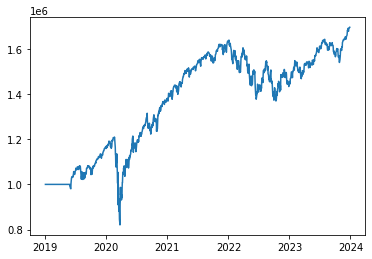

In [154]:
# Backtest
initial_capital = 1000000
holdings = pd.DataFrame(index=prices.index, columns=symbols)

num_shares = (weights.iloc[0] * initial_capital)/prices.iloc[0]
holdings.iloc[0] = prices.iloc[0]*num_shares
cash = [0]*len(prices)
cash[0] = initial_capital - holdings.iloc[0].sum()

for i in range(1,len(returns)): 
    holding = (prices.iloc[i]*num_shares).sum()
    value = holding + cash[i-1]
    
    num_shares = (weights.iloc[i] * initial_capital)/prices.iloc[i]
    holdings.iloc[i] = prices.iloc[i]*num_shares
    cash[i] = value - holdings.iloc[i].sum()
    
holdings.drop(holdings.tail(1).index,inplace=True)
value=cash[:len(cash)-1]+holdings.sum(axis=1)
print(weights)
plt.plot(value.index.date,value)